# NPS Error as a function of Sample Size and Sample Variance

This iPython notebook complements my blog post on https://codebeats.ml/blogpost/nps-score-quality-over-quantity. Here, I aim to demonstrate that NPS tracking can be reasonably reliable, even with a sample size as small as 40 respondents. This holds especially true when the sample standard deviation is lower.

In this notebook, I explore how NPS Error varies with changes in sample size and standard deviation. An interesting insight to highlight is that the margin of error (MoE) for a 100-respondent survey can be as significant as the MoE for a 30-respondent survey if the NPS ratings provided by customers exhibit high sample variance.

In other words, having 100 respondents for your NPS survey does not guarantee accurate results. If there is a high variance in the respondents' answers, the NPS score can be misleading and unreliable.

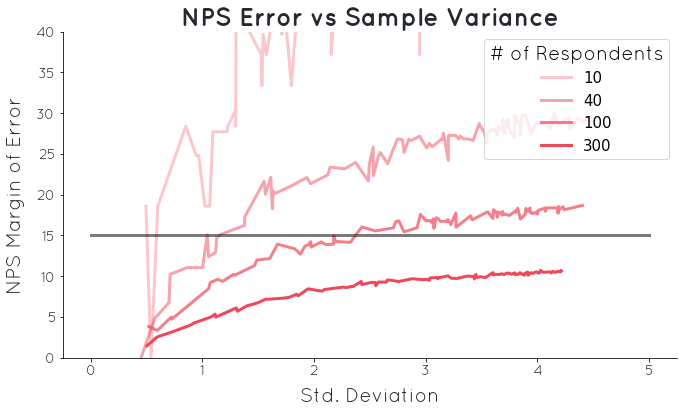

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.font_manager as fm

# Define an omega function such that average(omega) = NPS
def omega(entry):
  if entry <= 6:
    return -1 # detractor
  elif entry >= 9:
    return 1 # promoter
  else:
    return 0 # passive

# Function to generate a matrix with random NPS Surveys
def NPS_Survey_Generator(num_surveys, num_respondents, min_std, max_std):
    # The matrix rows will be the number of random surveys to be generated
    # Each column will repersent a respondent
    # Each entry of the matrix represent the NPS rate from 0 to 10 given by a respondent
    # Each survey (row) will have a different variance
    NPS_Surveys = np.zeros((num_surveys, num_respondents))
    
    # Generate a random survey (row) per iteration.
    for survey in range(num_surveys):
        # Each survey will have a slightly higher standard deviation than the previous survey
        std = min_std + survey * (max_std - min_std) / (num_surveys - 1)
        # Generate random NPS Scores with the given standard deviation and mean
        # In this case we've set 8 as the mean NPS rate given by all respondents
        NPS_Surveys[survey] = np.random.normal(8, std, num_respondents)
        # Clip the values to the given range, so we don't have NPS rates outside the range [0, 10]
        NPS_Surveys[survey] = np.clip(NPS_Surveys[survey], 0, 10)

    # Return the matrix
    return NPS_Surveys


# Calculate Margin of Error of each survey
def calculate_moe(matrix):
    # Initialize an empty list to store the average values
    moes = []

    for survey in range(len(matrix)):
        # Apply the omega function to each entry of the survey
        matrix[survey] = np.vectorize(lambda x: omega(x))(matrix[survey])
        # Calculate the Margin of Error of each survey
        # Multiply by then just to put it in percentage
        moe = ((np.std(matrix[survey]) / np.sqrt(len(matrix[survey])))*1.96) * 100 
        moes.append(moe)
    
    # Return the list of average values and the modified matrix
    return moes

# Function to order the rows of the NPS_Surveys matrix (each survey) according to their real standard deviation
def order_matrix(NPS_Surveys):
    # Initialize an empty list to store the effective standard deviations
    eff_stds = []

    for survey in NPS_Surveys:
        # Calculate the effective standard deviation of each survey
        eff_std = np.sqrt(np.var(survey))
        # Append the effective standard deviation to the list
        eff_stds.append(eff_std)

    # Sort the surveys (rows) of the matrix and their corresponding effective standard deviations in ascending order
    sorted_indices = np.argsort(eff_stds)
    sorted_NPS_Surveys = NPS_Surveys[sorted_indices]
    sorted_eff_stds = np.array(eff_stds)[sorted_indices]
    
    # Return the sorted NPS_Surveys matrix and its effective standard deviations
    return sorted_NPS_Surveys, sorted_eff_stds

# Generate 100 sample surveys, with 10 respondents
NPS_Surveys_10resp = NPS_Survey_Generator(100, 10, 0.5, 10)

# Generate 100 sample surveys, with 40 respondents
NPS_Surveys_40resp = NPS_Survey_Generator(100, 40, 0.5, 10)

# Generate 100 sample surveys, with 100 respondents
NPS_Surveys_100resp = NPS_Survey_Generator(100, 100, 0.5, 10)

# Generate 100 sample surveys, with 300 respondents
NPS_Surveys_300resp = NPS_Survey_Generator(100, 300, 0.5, 10)

# Order the rows of both matrices according to their effective standard deviation after scoring
NPS_Surveys_10resp, NPS_StDevs_10resp = order_matrix(NPS_Surveys_10resp)
NPS_Surveys_40resp, NPS_StDevs_40resp = order_matrix(NPS_Surveys_40resp)
NPS_Surveys_100resp, NPS_StDevs_100resp = order_matrix(NPS_Surveys_100resp)
NPS_Surveys_300resp, NPS_StDevs_300resp = order_matrix(NPS_Surveys_300resp)

# Calculate margin of error for each group of surveys.
moe_10resp = calculate_moe(NPS_Surveys_10resp)
moe_40resp = calculate_moe(NPS_Surveys_40resp)
moe_100resp = calculate_moe(NPS_Surveys_100resp)
moe_300resp = calculate_moe(NPS_Surveys_300resp)

# Horizontal line at 15 Margin of Error value
MOE_at_15_y = np.ones(100) * 15
MOE_at_15_x = np.linspace(0, 5, 100)

### Prepare graph ###
# Define fonts to use on Matplotlib plots.
TitleFont = fm.FontProperties(fname='Quicksand-Bold.otf', size=25)
AxisFont = fm.FontProperties(fname='Quicksand-Regular.otf', size=20)
TicksFont = fm.FontProperties(fname='Quicksand-Regular.otf', size=15)
# Titles and labels
fig, ax = plt.subplots(figsize=(11, 6))
plt.title('NPS Error vs Sample Variance', weight="bold", fontproperties=TitleFont, color="#242930")
ax.set_xlabel('Std. Deviation', labelpad=10, fontproperties=AxisFont, color="#242930")
ax.set_ylabel('NPS Margin of Error', labelpad=10, fontproperties=AxisFont, color="#242930")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 40)
ax.grid(False)
for label in ax.get_xticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#242930")

for label in ax.get_yticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#242930")
# Specify the desired y-axis tick spacing
y_major_locator = MultipleLocator(5)
plt.gca().yaxis.set_major_locator(y_major_locator)
####################

# Plot groups of surveys
plt.plot(NPS_StDevs_10resp, moe_10resp, label='10', linestyle='-', lw=3, color="#f04859", alpha=0.3)
plt.plot(NPS_StDevs_40resp, moe_40resp, label='40', linestyle='-', lw=3, color="#f04859", alpha=0.5)
plt.plot(NPS_StDevs_100resp, moe_100resp, label='100', linestyle='-', lw=3, color="#f04859", alpha=0.7)
plt.plot(NPS_StDevs_300resp, moe_300resp, label='300', linestyle='-', lw=3, color="#f04859")
plt.plot(MOE_at_15_x, MOE_at_15_y, linestyle='-', lw=3, color="#222222", alpha=0.6)

# Legend
font_properties = {'size': 15} 
legend = plt.legend(title="# of Respondents", prop=font_properties, loc='upper right')
legend.get_title().set_fontproperties(AxisFont)

plt.show()

## Find the ideal standard deviation values for 40 and 100 respondents sample sizes

We can repeatedly generate multiple matrices, where each row represents a random survey. For each matrix, we store the corresponding standard deviation that produces a survey with a margin of error greater than or equal to 15. This process is repeated 10,000 times for both 40-respondent and 100-respondent surveys. Finally, we calculate the average standard deviation value that yields a margin of error greater than or equal to 15.

In [7]:
Intersection_40_resp = []
for i in range(10000):
    NPS_Surveys_40resp = NPS_Survey_Generator(100, 40, 0.5, 10)
    NPS_Surveys_40resp, NPS_StDevs_40resp = order_matrix(NPS_Surveys_40resp)
    moe_40resp = calculate_moe(NPS_Surveys_40resp)
    for std, moe in zip(NPS_StDevs_40resp, moe_40resp):
        if moe >= 15:
            Intersection_40_resp.append(std)
            break

In [8]:
Intersection_100_resp = []
for i in range(10000):
    NPS_Surveys_100resp = NPS_Survey_Generator(100, 100, 0.5, 10)
    NPS_Surveys_100resp, NPS_StDevs_100resp = order_matrix(NPS_Surveys_100resp)
    moe_100resp = calculate_moe(NPS_Surveys_100resp)
    for std, moe in zip(NPS_StDevs_100resp, moe_100resp):
        if moe >= 15:
            Intersection_100_resp.append(std)
            break

In [23]:
print(f'A 40-respondent NPS survey has an expected margin of error equal to 15 when the sample standard deviation is: \n{"{:.2f}".format(np.mean(Intersection_40_resp))} ± {"{:.2f}".format(np.std(Intersection_40_resp))}')

A 40-respondent NPS survey has an expected margin of error equal to 15 when the sample standard deviation is: 
1.19 ± 0.09


In [22]:
print(f'A 100-respondent NPS survey has an expected margin of error equal to 15 when the sample standard deviation is: \n{"{:.2f}".format(np.mean(Intersection_100_resp))} ± {"{:.2f}".format(np.std(Intersection_100_resp))}')

A 100-respondent NPS survey has an expected margin of error equal to 15 when the sample standard deviation is: 
2.19 ± 0.11


## Conclusion

According to this, we can conclude that the margin of error of a 40 respondent survery is similar to a 100 respondent survey when the sample standard deviations are 1.19 ± 0.09 and 2.19 ± 0.11 respectively

More broadly, the following rule of thumb can be followed:

- For 1-30 responses, NPS scores are unreliable. Get more responses and call back your customers.
- For around 40 responses, you can track NPS if the sample standard deviation is below 1.2.
- For 40-100 responses, you can track NPS if the sample standard deviation is below 2.2. 
- Higher deviations may increase NPS error even with 100 responses.
- For over 300 responses, NPS scores are very reliable. High variance samples are not ideal though, because they show inconsistent customer experience and loyalty.